In [3]:
# Full working example of applying HistoryTreeProcessor on any website

import hashlib
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.chrome.options import Options

# --- Mocked Classes to Simulate Application Framework ---

class HashedDomElement:
    def __init__(self, branch_path_hash: str, attributes_hash: str, xpath_hash: str):
        self.branch_path_hash = branch_path_hash
        self.attributes_hash = attributes_hash
        self.xpath_hash = xpath_hash

    def __eq__(self, other):
        return (self.branch_path_hash == other.branch_path_hash and
                self.attributes_hash == other.attributes_hash and
                self.xpath_hash == other.xpath_hash)

class DOMElementNode:
    def __init__(self, tag_name, xpath, attributes, parent=None):
        self.tag_name = tag_name
        self.xpath = xpath
        self.attributes = attributes
        self.parent = parent
        self.children = []
        self.highlight_index = None  # Optional unique identifier

class DOMHistoryElement:
    def __init__(self, tag_name, xpath, highlight_index, entire_parent_branch_path, attributes, shadow_root=None, **kwargs):
        self.tag_name = tag_name
        self.xpath = xpath
        self.highlight_index = highlight_index
        self.entire_parent_branch_path = entire_parent_branch_path
        self.attributes = attributes
        self.shadow_root = shadow_root

class BrowserContext:
    @staticmethod
    def _enhanced_css_selector_for_element(dom_element: DOMElementNode):
        return dom_element.xpath  # Placeholder for demo

# --- HistoryTreeProcessor as Given ---

class HistoryTreeProcessor:
    @staticmethod
    def convert_dom_element_to_history_element(dom_element: DOMElementNode) -> DOMHistoryElement:
        parent_branch_path = HistoryTreeProcessor._get_parent_branch_path(dom_element)
        css_selector = BrowserContext._enhanced_css_selector_for_element(dom_element)
        return DOMHistoryElement(
            dom_element.tag_name,
            dom_element.xpath,
            dom_element.highlight_index,
            parent_branch_path,
            dom_element.attributes,
            shadow_root=None,
            css_selector=css_selector,
        )

    @staticmethod
    def find_history_element_in_tree(dom_history_element: DOMHistoryElement, tree: DOMElementNode):
        hashed_dom_history_element = HistoryTreeProcessor._hash_dom_history_element(dom_history_element)

        def process_node(node: DOMElementNode):
            if node.highlight_index is not None:
                hashed_node = HistoryTreeProcessor._hash_dom_element(node)
                if hashed_node == hashed_dom_history_element:
                    return node
            for child in node.children:
                result = process_node(child)
                if result:
                    return result
            return None

        return process_node(tree)

    @staticmethod
    def _hash_dom_history_element(dom_history_element: DOMHistoryElement) -> HashedDomElement:
        return HashedDomElement(
            HistoryTreeProcessor._parent_branch_path_hash(dom_history_element.entire_parent_branch_path),
            HistoryTreeProcessor._attributes_hash(dom_history_element.attributes),
            HistoryTreeProcessor._xpath_hash(dom_history_element.xpath),
        )

    @staticmethod
    def _hash_dom_element(dom_element: DOMElementNode) -> HashedDomElement:
        return HashedDomElement(
            HistoryTreeProcessor._parent_branch_path_hash(
                HistoryTreeProcessor._get_parent_branch_path(dom_element)
            ),
            HistoryTreeProcessor._attributes_hash(dom_element.attributes),
            HistoryTreeProcessor._xpath_hash(dom_element.xpath),
        )

    @staticmethod
    def _get_parent_branch_path(dom_element: DOMElementNode):
        parents = []
        current = dom_element
        while current.parent:
            parents.append(current)
            current = current.parent
        parents.reverse()
        return [p.tag_name for p in parents]

    @staticmethod
    def _parent_branch_path_hash(path):
        return hashlib.sha256('/'.join(path).encode()).hexdigest()

    @staticmethod
    def _attributes_hash(attributes):
        return hashlib.sha256(
            ''.join(f"{k}={v}" for k, v in sorted(attributes.items())).encode()
        ).hexdigest()

    @staticmethod
    def _xpath_hash(xpath):
        return hashlib.sha256(xpath.encode()).hexdigest()

# --- DOM Builder from BeautifulSoup ---

def generate_xpath(bs_elem):
    path = []
    while bs_elem and bs_elem.name:
        index = ''
        if bs_elem.parent:
            siblings = [s for s in bs_elem.parent.find_all(bs_elem.name, recursive=False)]
            if len(siblings) > 1:
                index = f"[{siblings.index(bs_elem)+1}]"
        path.insert(0, f"/{bs_elem.name}{index}")
        bs_elem = bs_elem.parent
    return ''.join(path)

def build_dom_tree(bs_node, parent=None):
    if not hasattr(bs_node, 'name') or bs_node.name is None:
        return None

    node = DOMElementNode(
        tag_name=bs_node.name,
        xpath=generate_xpath(bs_node),
        attributes=dict(bs_node.attrs),
        parent=parent
    )
    if parent:
        parent.children.append(node)

    for child in bs_node.children:
        child_node = build_dom_tree(child, parent=node)

    return node

# --- Main Application Logic ---

# Define main first
def main():
    url = "https://www.swiggy.com"

    chrome_options = Options()
    chrome_options.add_argument("--headless")
    driver = webdriver.Chrome(options=chrome_options)
    driver.get(url)

    soup = BeautifulSoup(driver.page_source, 'html.parser')
    driver.quit()

    root_node = build_dom_tree(soup.body)

    # Pick the first valid child to create a history element snapshot
    target_node = root_node.children[0]
    target_node.highlight_index = 1  # Simulate ID

    history_element = HistoryTreeProcessor.convert_dom_element_to_history_element(target_node)

    # Try to find it again in the DOM
    found_node = HistoryTreeProcessor.find_history_element_in_tree(history_element, root_node)

    print("Match Found:", found_node is not None)
    print("Original XPath:", target_node.xpath)
    print("Found XPath:", found_node.xpath if found_node else None)

    return root_node

# Call main after it's defined
if __name__ == '__main__':
    root = main()

    # Optional: print the DOM structure
    def print_dom_tree(node, depth=0):
        if node is None:
            return
        print("  " * depth + f"<{node.tag_name}>")
        for child in node.children:
            print_dom_tree(child, depth + 1)

    print("\nDOM Tree Structure:")
    print_dom_tree(root)



Match Found: True
Original XPath: /[document]/html/body/div
Found XPath: /[document]/html/body/div

DOM Tree Structure:
<body>
  <div>
    <div>
      <header>
        <div>
          <div>
            <a>
              <svg>
                <g>
                  <path>
                  <path>
                <defs>
                  <clippath>
                    <path>
            <ul>
              <li>
                <div>
                  <div>
                    <div>
                      <a>
                        <span>
                          <svg>
                            <path>
                          <span>
                        <span>
              <li>
                <div>
                  <span>
                    <svg>
                      <path>
                  <span>
              <li>
                <div>
                  <a>
                    <span>
                      <svg>
                        <path>
              <li>
               

Match Found: True
Original XPath: /[document]/html/body/a[1]
Found XPath: /[document]/html/body/a[1]


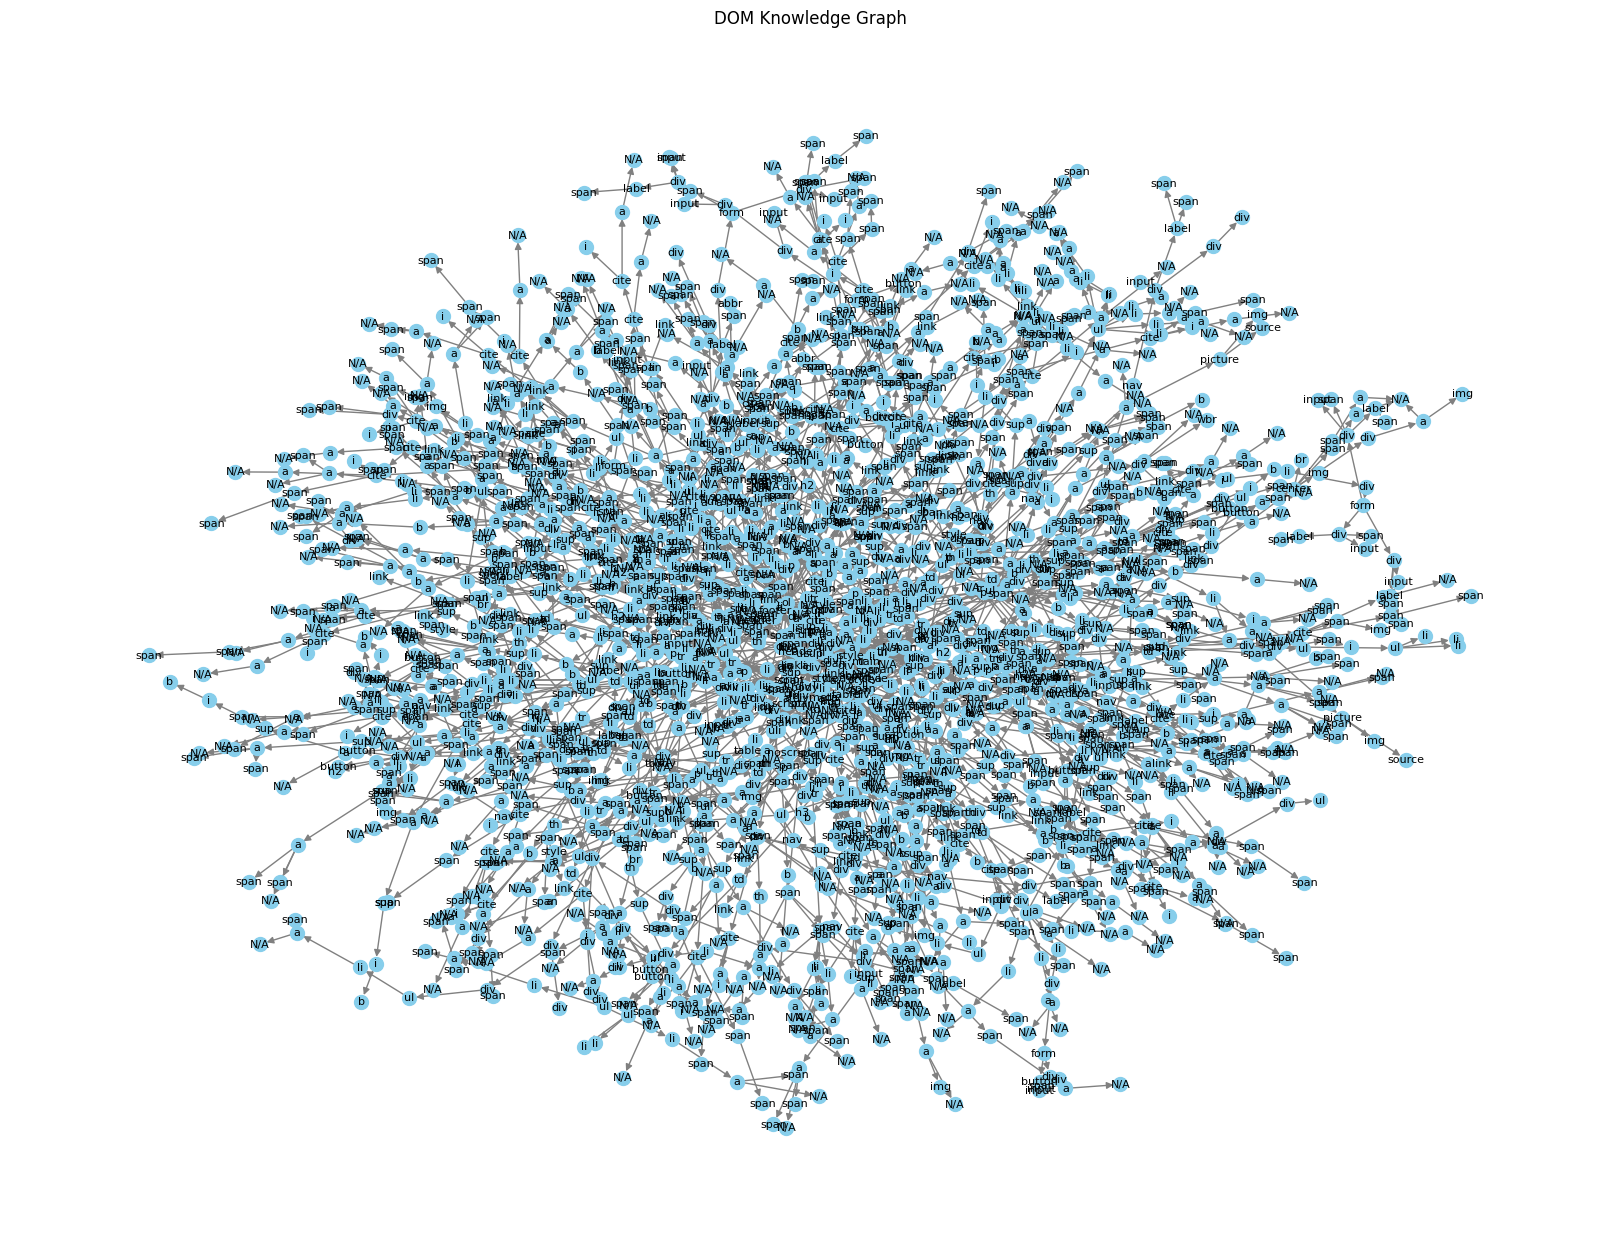

📸 Knowledge graph saved as dom_knowledge_graph.png and shown above.

DOM Tree Structure:
<body>
  <a>
  <div>
    <header>
      <div>
        <nav>
          <div>
            <input>
            <label>
              <span>
              <span>
            <div>
              <div>
                <div>
                  <div>
                    <div>
                    <button>
                    <button>
                  <div>
                    <div>
                    <div>
                      <ul>
                        <li>
                          <a>
                            <span>
                        <li>
                          <a>
                            <span>
                        <li>
                          <a>
                            <span>
                        <li>
                          <a>
                            <span>
                        <li>
                          <a>
                            <span>
            

In [10]:
  # Full working example of applying HistoryTreeProcessor on any website

import hashlib
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
import networkx as nx  # Added for Knowledge Graph

# --- Mocked Classes to Simulate Application Framework ---

class HashedDomElement:
    def __init__(self, branch_path_hash: str, attributes_hash: str, xpath_hash: str):
        self.branch_path_hash = branch_path_hash
        self.attributes_hash = attributes_hash
        self.xpath_hash = xpath_hash

    def __eq__(self, other):
        return (self.branch_path_hash == other.branch_path_hash and
                self.attributes_hash == other.attributes_hash and
                self.xpath_hash == other.xpath_hash)

class DOMElementNode:
    def __init__(self, tag_name, xpath, attributes, parent=None):
        self.tag_name = tag_name
        self.xpath = xpath
        self.attributes = attributes
        self.parent = parent
        self.children = []
        self.highlight_index = None

class DOMHistoryElement:
    def __init__(self, tag_name, xpath, highlight_index, entire_parent_branch_path, attributes, shadow_root=None, **kwargs):
        self.tag_name = tag_name
        self.xpath = xpath
        self.highlight_index = highlight_index
        self.entire_parent_branch_path = entire_parent_branch_path
        self.attributes = attributes
        self.shadow_root = shadow_root

class BrowserContext:
    @staticmethod
    def _enhanced_css_selector_for_element(dom_element: DOMElementNode):
        return dom_element.xpath

class HistoryTreeProcessor:
    @staticmethod
    def convert_dom_element_to_history_element(dom_element: DOMElementNode) -> DOMHistoryElement:
        parent_branch_path = HistoryTreeProcessor._get_parent_branch_path(dom_element)
        css_selector = BrowserContext._enhanced_css_selector_for_element(dom_element)
        return DOMHistoryElement(
            dom_element.tag_name,
            dom_element.xpath,
            dom_element.highlight_index,
            parent_branch_path,
            dom_element.attributes,
            shadow_root=None,
            css_selector=css_selector,
        )

    @staticmethod
    def find_history_element_in_tree(dom_history_element: DOMHistoryElement, tree: DOMElementNode):
        hashed_dom_history_element = HistoryTreeProcessor._hash_dom_history_element(dom_history_element)

        def process_node(node: DOMElementNode):
            if node.highlight_index is not None:
                hashed_node = HistoryTreeProcessor._hash_dom_element(node)
                if hashed_node == hashed_dom_history_element:
                    return node
            for child in node.children:
                result = process_node(child)
                if result:
                    return result
            return None

        return process_node(tree)

    @staticmethod
    def _hash_dom_history_element(dom_history_element: DOMHistoryElement) -> HashedDomElement:
        return HashedDomElement(
            HistoryTreeProcessor._parent_branch_path_hash(dom_history_element.entire_parent_branch_path),
            HistoryTreeProcessor._attributes_hash(dom_history_element.attributes),
            HistoryTreeProcessor._xpath_hash(dom_history_element.xpath),
        )

    @staticmethod
    def _hash_dom_element(dom_element: DOMElementNode) -> HashedDomElement:
        return HashedDomElement(
            HistoryTreeProcessor._parent_branch_path_hash(
                HistoryTreeProcessor._get_parent_branch_path(dom_element)
            ),
            HistoryTreeProcessor._attributes_hash(dom_element.attributes),
            HistoryTreeProcessor._xpath_hash(dom_element.xpath),
        )

    @staticmethod
    def _get_parent_branch_path(dom_element: DOMElementNode):
        parents = []
        current = dom_element
        while current.parent:
            parents.append(current)
            current = current.parent
        parents.reverse()
        return [p.tag_name for p in parents]

    @staticmethod
    def _parent_branch_path_hash(path):
        return hashlib.sha256('/'.join(path).encode()).hexdigest()

    @staticmethod
    def _attributes_hash(attributes):
        return hashlib.sha256(
            ''.join(f"{k}={v}" for k, v in sorted(attributes.items())).encode()
        ).hexdigest()

    @staticmethod
    def _xpath_hash(xpath):
        return hashlib.sha256(xpath.encode()).hexdigest()

def generate_xpath(bs_elem):
    path = []
    while bs_elem and bs_elem.name:
        index = ''
        if bs_elem.parent:
            siblings = [s for s in bs_elem.parent.find_all(bs_elem.name, recursive=False)]
            if len(siblings) > 1:
                index = f"[{siblings.index(bs_elem)+1}]"
        path.insert(0, f"/{bs_elem.name}{index}")
        bs_elem = bs_elem.parent
    return ''.join(path)

def build_dom_tree(bs_node, parent=None):
    if not hasattr(bs_node, 'name') or bs_node.name is None:
        return None

    node = DOMElementNode(
        tag_name=bs_node.name,
        xpath=generate_xpath(bs_node),
        attributes=dict(bs_node.attrs),
        parent=parent
    )
    if parent:
        parent.children.append(node)

    for child in bs_node.children:
        build_dom_tree(child, parent=node)

    return node

def build_knowledge_graph_from_dom(root_node: DOMElementNode):
    G = nx.DiGraph()

    def recurse(node):
        node_id = node.xpath
        attrs = {f"attr_{k}": str(v) for k, v in node.attributes.items() if not isinstance(v, list)}
        G.add_node(node_id, tag=node.tag_name, **attrs)

        for child in node.children:
            child_id = child.xpath
            G.add_edge(node_id, child_id, relation="contains")
            recurse(child)

        if node.tag_name == "a" and "href" in node.attributes:
            href = node.attributes["href"]
            G.add_edge(node_id, href, relation="links_to")

    recurse(root_node)
    return G

def main():
    url = "https://en.wikipedia.org/wiki/Swiggy"

    chrome_options = Options()
    chrome_options.add_argument("--headless")
    driver = webdriver.Chrome(options=chrome_options)
    driver.get(url)

    soup = BeautifulSoup(driver.page_source, 'html.parser')
    driver.quit()

    root_node = build_dom_tree(soup.body)
    target_node = root_node.children[0]
    target_node.highlight_index = 1

    history_element = HistoryTreeProcessor.convert_dom_element_to_history_element(target_node)
    found_node = HistoryTreeProcessor.find_history_element_in_tree(history_element, root_node)

    print("Match Found:", found_node is not None)
    print("Original XPath:", target_node.xpath)
    print("Found XPath:", found_node.xpath if found_node else None)

    import matplotlib.pyplot as plt

# Build knowledge graph
    KG = build_knowledge_graph_from_dom(root_node)

# Draw the knowledge graph
    plt.figure(figsize=(16, 12))
    pos = nx.spring_layout(KG, k=0.5)

# Draw nodes and edges
    nx.draw(KG, pos, with_labels=False, node_size=100, node_color="skyblue", edge_color="gray", arrows=True)

# Draw node labels using tag name or 'N/A' if missing
    nx.draw_networkx_labels(
    KG,
    pos,
    labels={n: d.get('tag', 'N/A') for n, d in KG.nodes(data=True)},
    font_size=8
     )

# Save and show the image
    plt.title("DOM Knowledge Graph")
    plt.savefig("dom_knowledge_graph.png", dpi=300)
    plt.show()
    print("📸 Knowledge graph saved as dom_knowledge_graph.png and shown above.")



    return root_node

if __name__ == '__main__':
    root = main()

    def print_dom_tree(node, depth=0):
        if node is None:
            return
        print("  " * depth + f"<{node.tag_name}>")
        for child in node.children:
            print_dom_tree(child, depth + 1)

    print("\nDOM Tree Structure:")
    print_dom_tree(root)


In [4]:
import hashlib
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
import json
from anytree import Node, RenderTree
from anytree.exporter import DotExporter

# --- DOM Classes ---

class DOMElementNode:
    def __init__(self, tag_name, xpath, attributes, parent=None):
        self.tag_name = tag_name
        self.xpath = xpath
        self.attributes = attributes
        self.parent = parent
        self.children = []
        self.highlight_index = None

# --- Utilities ---

def generate_xpath(bs_elem):
    path = []
    while bs_elem and bs_elem.name:
        index = ''
        if bs_elem.parent:
            siblings = [s for s in bs_elem.parent.find_all(bs_elem.name, recursive=False)]
            if len(siblings) > 1:
                index = f"[{siblings.index(bs_elem)+1}]"
        path.insert(0, f"/{bs_elem.name}{index}")
        bs_elem = bs_elem.parent
    return ''.join(path)

def build_dom_tree(bs_node, parent=None):
    if not hasattr(bs_node, 'name') or bs_node.name is None:
        return None

    node = DOMElementNode(
        tag_name=bs_node.name,
        xpath=generate_xpath(bs_node),
        attributes=dict(bs_node.attrs),
        parent=parent
    )
    if parent:
        parent.children.append(node)

    for child in bs_node.children:
        build_dom_tree(child, parent=node)

    return node

# --- Taxonomy Extraction ---

SEMANTIC_TAGS = {"header", "nav", "main", "section", "article", "aside", "footer", "h1", "h2", "h3", "ul", "li", "a"}

def extract_taxonomy(node: DOMElementNode):
    if not node:
        return None

    tag = node.tag_name
    if tag not in SEMANTIC_TAGS:
        child_taxonomies = [extract_taxonomy(child) for child in node.children]
        merged = {}
        for child in child_taxonomies:
            if isinstance(child, dict):
                for k, v in child.items():
                    merged.setdefault(k, []).extend(v if isinstance(v, list) else [v])
        return merged if merged else None

    label = None
    if tag in ['h1', 'h2', 'h3']:
        label = node.attributes.get('id') or f"{tag}_heading"
    elif tag == 'a':
        label = node.attributes.get('href') or 'link'
    elif tag == 'li':
        label = node.attributes.get('id') or 'list_item'

    children_taxonomy = []
    for child in node.children:
        t = extract_taxonomy(child)
        if t:
            children_taxonomy.append(t)

    node_entry = label if not children_taxonomy else {label or tag: children_taxonomy}
    return {tag: [node_entry]} if node_entry else None

# --- Build Tree from Taxonomy ---

def build_tree(data, parent=None, label="root"):
    node = Node(label, parent=parent)
    if isinstance(data, dict):
        for key, children in data.items():
            for child in children:
                build_tree(child, parent=node, label=key)
    elif isinstance(data, list):
        for item in data:
            build_tree(item, parent=node, label=label)
    elif isinstance(data, str):
        Node(data, parent=node)
    return node

# --- Main ---

def main():
    url = "https://en.wikipedia.org/wiki/Swiggy"

    chrome_options = Options()
    chrome_options.add_argument("--headless")
    driver = webdriver.Chrome(options=chrome_options)
    driver.get(url)

    soup = BeautifulSoup(driver.page_source, 'html.parser')
    driver.quit()

    root_node = build_dom_tree(soup.body)
    taxonomy = extract_taxonomy(root_node)

    clickable_elements = ClickableElementProcessor.get_clickable_elements(root_node)

    print("\n🖱️ Clickable Elements Found:\n")
    for el in clickable_elements:
       print(f"Tag: <{el.tag_name}> | XPath: {el.xpath} | Attributes: {el.attributes}")


    print("\n📚 Website Taxonomy Tree (JSON):\n")
    print(json.dumps(taxonomy, indent=2))

    return taxonomy

class ClickableElementProcessor:
    @staticmethod
    def get_clickable_elements_hashes(dom_element: DOMElementNode) -> set[str]:
        clickable_elements = ClickableElementProcessor.get_clickable_elements(dom_element)
        return {ClickableElementProcessor.hash_dom_element(element) for element in clickable_elements}

    @staticmethod
    def get_clickable_elements(dom_element: DOMElementNode) -> list[DOMElementNode]:
        clickable_elements = []
        for child in dom_element.children:
            if isinstance(child, DOMElementNode):
                if child.highlight_index:
                    clickable_elements.append(child)
                clickable_elements.extend(ClickableElementProcessor.get_clickable_elements(child))
        return clickable_elements

    @staticmethod
    def hash_dom_element(dom_element: DOMElementNode) -> str:
        parent_branch_path = ClickableElementProcessor._get_parent_branch_path(dom_element)
        branch_path_hash = ClickableElementProcessor._parent_branch_path_hash(parent_branch_path)
        attributes_hash = ClickableElementProcessor._attributes_hash(dom_element.attributes)
        xpath_hash = ClickableElementProcessor._xpath_hash(dom_element.xpath)
        return ClickableElementProcessor._hash_string(f'{branch_path_hash}-{attributes_hash}-{xpath_hash}')

    @staticmethod
    def _get_parent_branch_path(dom_element: DOMElementNode) -> list[str]:
        parents = []
        current = dom_element
        while current.parent is not None:
            parents.append(current)
            current = current.parent
        parents.reverse()
        return [parent.tag_name for parent in parents]

    @staticmethod
    def _parent_branch_path_hash(parent_branch_path: list[str]) -> str:
        return hashlib.sha256('/'.join(parent_branch_path).encode()).hexdigest()

    @staticmethod
    def _attributes_hash(attributes: dict[str, str]) -> str:
        return hashlib.sha256(''.join(f'{k}={v}' for k, v in sorted(attributes.items())).encode()).hexdigest()

    @staticmethod
    def _xpath_hash(xpath: str) -> str:
        return hashlib.sha256(xpath.encode()).hexdigest()

    @staticmethod
    def _hash_string(string: str) -> str:
        return hashlib.sha256(string.encode()).hexdigest()


# --- Entry Point ---

if __name__ == '__main__':
    taxonomy = main()  # ⬅️ FIXED: now you get taxonomy from main()

    print("\n🌳 Tree View of Taxonomy:\n")
    root_tree = build_tree(taxonomy, label="Website")

    for pre, _, node in RenderTree(root_tree):
        print(f"{pre}{node.name}")



🖱️ Clickable Elements Found:


📚 Website Taxonomy Tree (JSON):

{
  "a": [
    "#bodyContent",
    "#",
    "https://commons.wikimedia.org/wiki/Commons:Wiki_Loves_Earth_2025_in_India",
    "https://commons.wikimedia.org/wiki/Commons:Wiki_Loves_Earth_2025_in_India",
    "https://commons.wikimedia.org/wiki/Commons:Wiki_Loves_Earth_2025_in_India",
    "#",
    "#",
    "#",
    "#",
    "#",
    "#",
    "#",
    "#",
    "https://en.wikipedia.org/wiki/Swiggy?action=edit"
  ],
  "header": [
    {
      "header": [
        {
          "nav": [
            {
              "nav": [
                {
                  "ul": [
                    {
                      "ul": [
                        {
                          "li": [
                            {
                              "n-mainpage-description": [
                                {
                                  "a": [
                                    "/wiki/Main_Page"
                                  ]
       

In [5]:
import hashlib
import json
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from anytree import Node, RenderTree
from anytree.exporter import DotExporter

# --- DOM Classes ---

class DOMElementNode:
    def __init__(self, tag_name, xpath, attributes, parent=None):
        self.tag_name = tag_name
        self.xpath = xpath
        self.attributes = attributes
        self.parent = parent
        self.children = []
        self.highlight_index = None

# --- Constants ---
CLICKABLE_TAGS = {"a", "button", "input", "select", "textarea", "label"}

SEMANTIC_TAGS = {"header", "nav", "main", "section", "article", "aside",
                 "footer", "h1", "h2", "h3", "ul", "li", "a"}

# --- Utilities ---

def generate_xpath(bs_elem):
    path = []
    while bs_elem and bs_elem.name:
        index = ''
        if bs_elem.parent:
            siblings = [s for s in bs_elem.parent.find_all(bs_elem.name, recursive=False)]
            if len(siblings) > 1:
                index = f"[{siblings.index(bs_elem)+1}]"
        path.insert(0, f"/{bs_elem.name}{index}")
        bs_elem = bs_elem.parent
    return ''.join(path)

def build_dom_tree(bs_node, parent=None):
    if not hasattr(bs_node, 'name') or bs_node.name is None:
        return None

    node = DOMElementNode(
        tag_name=bs_node.name,
        xpath=generate_xpath(bs_node),
        attributes=dict(bs_node.attrs),
        parent=parent
    )

    # ✅ Mark as clickable
    if bs_node.name in CLICKABLE_TAGS or 'onclick' in bs_node.attrs:
        node.highlight_index = 1

    if parent:
        parent.children.append(node)

    for child in bs_node.children:
        build_dom_tree(child, parent=node)

    return node

# --- Taxonomy Extraction ---

def extract_taxonomy(node: DOMElementNode):
    if not node:
        return None

    tag = node.tag_name
    if tag not in SEMANTIC_TAGS:
        child_taxonomies = [extract_taxonomy(child) for child in node.children]
        merged = {}
        for child in child_taxonomies:
            if isinstance(child, dict):
                for k, v in child.items():
                    merged.setdefault(k, []).extend(v if isinstance(v, list) else [v])
        return merged if merged else None

    label = None
    if tag in ['h1', 'h2', 'h3']:
        label = node.attributes.get('id') or f"{tag}_heading"
    elif tag == 'a':
        label = node.attributes.get('href') or 'link'
    elif tag == 'li':
        label = node.attributes.get('id') or 'list_item'

    children_taxonomy = []
    for child in node.children:
        t = extract_taxonomy(child)
        if t:
            children_taxonomy.append(t)

    node_entry = label if not children_taxonomy else {label or tag: children_taxonomy}
    return {tag: [node_entry]} if node_entry else None

# --- Tree Builder for Taxonomy ---

def build_tree(data, parent=None, label="root"):
    node = Node(label, parent=parent)
    if isinstance(data, dict):
        for key, children in data.items():
            for child in children:
                build_tree(child, parent=node, label=key)
    elif isinstance(data, list):
        for item in data:
            build_tree(item, parent=node, label=label)
    elif isinstance(data, str):
        Node(data, parent=node)
    return node

# --- Clickable Element Processor ---

class ClickableElementProcessor:
    @staticmethod
    def get_clickable_elements_hashes(dom_element: DOMElementNode) -> set[str]:
        clickable_elements = ClickableElementProcessor.get_clickable_elements(dom_element)
        return {ClickableElementProcessor.hash_dom_element(element) for element in clickable_elements}

    @staticmethod
    def get_clickable_elements(dom_element: DOMElementNode) -> list[DOMElementNode]:
        clickable_elements = []
        for child in dom_element.children:
            if isinstance(child, DOMElementNode):
                if child.highlight_index:
                    clickable_elements.append(child)
                clickable_elements.extend(ClickableElementProcessor.get_clickable_elements(child))
        return clickable_elements

    @staticmethod
    def hash_dom_element(dom_element: DOMElementNode) -> str:
        parent_branch_path = ClickableElementProcessor._get_parent_branch_path(dom_element)
        branch_path_hash = ClickableElementProcessor._parent_branch_path_hash(parent_branch_path)
        attributes_hash = ClickableElementProcessor._attributes_hash(dom_element.attributes)
        xpath_hash = ClickableElementProcessor._xpath_hash(dom_element.xpath)
        return ClickableElementProcessor._hash_string(f'{branch_path_hash}-{attributes_hash}-{xpath_hash}')

    @staticmethod
    def _get_parent_branch_path(dom_element: DOMElementNode) -> list[str]:
        parents = []
        current = dom_element
        while current.parent is not None:
            parents.append(current)
            current = current.parent
        parents.reverse()
        return [parent.tag_name for parent in parents]

    @staticmethod
    def _parent_branch_path_hash(parent_branch_path: list[str]) -> str:
        return hashlib.sha256('/'.join(parent_branch_path).encode()).hexdigest()

    @staticmethod
    def _attributes_hash(attributes: dict[str, str]) -> str:
        return hashlib.sha256(''.join(f'{k}={v}' for k, v in sorted(attributes.items())).encode()).hexdigest()

    @staticmethod
    def _xpath_hash(xpath: str) -> str:
        return hashlib.sha256(xpath.encode()).hexdigest()

    @staticmethod
    def _hash_string(string: str) -> str:
        return hashlib.sha256(string.encode()).hexdigest()

# --- Main Program ---

def main():
    url = "https://en.wikipedia.org/wiki/Swiggy"

    chrome_options = Options()
    chrome_options.add_argument("--headless")
    driver = webdriver.Chrome(options=chrome_options)
    driver.get(url)

    soup = BeautifulSoup(driver.page_source, 'html.parser')
    driver.quit()

    root_node = build_dom_tree(soup.body)
    taxonomy = extract_taxonomy(root_node)

    # ✅ Get clickable elements
    clickable_elements = ClickableElementProcessor.get_clickable_elements(root_node)

    print("\n🖱️ Clickable Elements Found:\n")
    for el in clickable_elements:
        print(f"Tag: <{el.tag_name}> | XPath: {el.xpath} | Attributes: {el.attributes}")

    print("\n📚 Website Taxonomy Tree (JSON):\n")
    print(json.dumps(taxonomy, indent=2))

    return taxonomy

# --- Run ---

if __name__ == '__main__':
    taxonomy = main()

    print("\n🌳 Tree View of Taxonomy:\n")
    root_tree = build_tree(taxonomy, label="Website")

    for pre, _, node in RenderTree(root_tree):
        print(f"{pre}{node.name}")



🖱️ Clickable Elements Found:

Tag: <a> | XPath: /[document]/html/body/a[1] | Attributes: {'class': ['mw-jump-link'], 'href': '#bodyContent'}
Tag: <input> | XPath: /[document]/html/body/div[1]/header/div[1]/nav/div/input | Attributes: {'type': 'checkbox', 'id': 'vector-main-menu-dropdown-checkbox', 'role': 'button', 'aria-haspopup': 'true', 'data-event-name': 'ui.dropdown-vector-main-menu-dropdown', 'class': ['vector-dropdown-checkbox'], 'aria-label': 'Main menu'}
Tag: <label> | XPath: /[document]/html/body/div[1]/header/div[1]/nav/div/label | Attributes: {'id': 'vector-main-menu-dropdown-label', 'for': 'vector-main-menu-dropdown-checkbox', 'class': ['vector-dropdown-label', 'cdx-button', 'cdx-button--fake-button', 'cdx-button--fake-button--enabled', 'cdx-button--weight-quiet', 'cdx-button--icon-only'], 'aria-hidden': 'true'}
Tag: <button> | XPath: /[document]/html/body/div[1]/header/div[1]/nav/div/div/div/div/div[1]/button[1] | Attributes: {'class': ['vector-pinnable-header-toggle-but